In [1]:
import os
import itertools
import random
from collections import defaultdict

import numpy as np
from tqdm import tqdm

from rule import *

In [65]:
#find different rules which let through the same stimuli?
#create all possible stimuli matrix
n = 5
stim_a = list(itertools.product([0, 1], repeat=5))
#randomize a rule
new_r = Rule()
new_r.randomize_rule()

In [3]:
new_r.f_rule

'feature[2]==1'

In [14]:
defaultdict(list[int])
#w_count = defaultdict(int)
#for word in text:
#    w_count[word] += 1

defaultdict(list[int], {})

In [67]:
rule_passes = defaultdict(list[int])
max_nr_rules = 2042
#startup
new_r = Rule()
new_r.randomize_rule()

for val in tqdm(range(max_nr_rules)):
    #randomize a new rule
    while new_r.v_rule in rule_passes.keys():
        new_r = Rule()
        new_r.randomize_rule()
    #iterate over all stim
    pass_list = []
    for feature in stim_a:
        result = new_r.check_stimuli(feature)
        
        if result==True:
            pass_list.append(feature)

    rule_passes[new_r.v_rule] = pass_list
    
#save rule, and which stimuli pass

100%|██████████| 2042/2042 [00:15<00:00, 135.51it/s]


In [ ]:
#categorize?
#look at rule, how many involved, how many it lets through?

In [125]:
#get lens assume equal effort, regardless of the placing of the parenthesees

r_list = list(rule_passes.items())
row_list = []
for rule in r_list:
    #complexity
    try:
       r_l = rule[0].split()
    except AttributeError:
       continue
    #remove ()
    r_l = [i for i in r_l if i not in ["(",")"]]
    checked_features = (len(r_l) + 1) / 2
    passed_stim = len(rule[1])

    row = {"rule":rule[0],
           "nr_features":checked_features,
           "nr_passes":passed_stim,
           "passes":rule[1]}
    row_list.append(row)
    


In [4]:
from datasets import Dataset, concatenate_datasets

c:\alien_filter\alien_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
from plotnine import *
import pandas as pd

In [ ]:
## simple agent setup


######### 1 sample from rules
# vars - memory - nr_samples
# how they are sampled? 
# A, random
# B, similar (foraging)
# C, meta
#   C1, by nr_features
#   C2, by logic (read up on logic complexity computationally)
#   C3, by mix?
# D, by mix of the above?

######### 2 encounter stimuli 

# A, test based on one of the rules
#   How rule is selected? 
#    A, Probabilistic? softmax function?
#    B, hypothesis testing? one of the rules is selected to test multiple times despite its prob?
#    C,  mix of these?

# B, update weights, how ???
#    A, uniform? everything that was in accordance changes by x amount
#    A1, what is x?? 1? 0.1
#    B, 
# B2, update weights, when ???
#    A, without choice? 
#      test all rules "simultaneously"
#    B, test one exact rule, and let its result affect the rest?
#       B1, by proximity? (graph like rule connections, closer rules affected more?)
#       B2, by some memory degradation? (rules are ordered in memory sequence, ones further in line are less affected?)

# 3 resample
# When?
#   A, instantly when a rule approaches 0
#   B, at given intervals
#   C, at random itervals
#   D, based on some hypothesis testing? in connection with previous points, e.g when rule 1 is falsified, resample all?
# How?
#   A, remove from sampling pool,
#   B, Keep in sampling pool,
#   C, keep in sampling pool but lessen chance of resampling
# What's the limit?
#   A, set limit, less than e.g 0.1
#   B, dynamix limit
#       B1, based on n_max, e.g (1/n_max)/2?
#       B2, based on the p of the other rules?
#       B3, based on changing, if unchanged for x turns etc.
# HOW TO RESAMPLE??? (similar to original choice)
#   A, by meta???
#   B, KEEP previous choices in memory? Why would you select a new rule with blue, if ble was out one turn ago
#   B1, how much memory to keep 5+-2?
#   B2, remove rules based on important features? e.g if Blue out, don't select blue and x again
#   B3, remove by rule proximity?

# 4 choose rule
# ok, we have the  probs, but how to determine the rule?
# A, make choices always based on the top rule first, and then infer the rest, based on the result, (add memory attention etc)
# B, keep simultaneous eval, set threshold like 0.6
# C, dual-phase exploration/exploitation?

In [47]:
def random_sampler(rule_ds:Dataset,nr_samples:int):
    s = random.sample(range(len(rule_ds)),nr_samples)
    
    return Dataset.from_dict(rule_ds[s])

def compare_stimuli_all(rule_ds:Dataset,
                        stimuli:list[int],
                        real_rule:Rule,
                        learning_rate:float=0.1):

    #check if stimuli passes for all rules
    if stimuli in rule_ds["passes"]:
        passed_stim = True
    else:
        passed_stim = False
    rule_ds.update({"passed_stim":passed_stim})
    #check result
    res = real_rule.check_stimuli(stimuli)
    if res == rule_ds["passed_stim"]:
        correct = learning_rate
    else:
        correct = 0

    #if already exist, update:
    try:
        if rule_ds["correct"] == None:
            rule_ds.update({"correct":0})
        correct = correct + rule_ds["correct"]
    except KeyError:
        pass

  
    rule_ds.update({"correct":correct})
    return rule_ds

def proportional_re_weigh(rule_ds,weights:list[float]):
    #add up
    w_sums = sum(weights)
    try:
        new_weight = rule_ds["correct"] / w_sums
    except ZeroDivisionError:
        new_weight = 0
    rule_ds.update({"correct":new_weight})
    return rule_ds

In [ ]:
def random_sampler_remove(all_rules_ds:Dataset,
                   nr_samples:int):
    s1 = random.sample(range(len(all_rules_ds)),nr_samples)
    new_ds = Dataset.from_dict(all_rules_ds[s1])
    all_rules_ds = all_rules_ds.filter(lambda ds:ds["rule"] not in new_ds["rule"])
    
    
    return new_ds, all_rules_ds



In [ ]:
def instant_resample_filter(rule_ds:Dataset,
                      removed_rules:list[str],
                      limit:float=0.1):
    """
    removes rules with p~0,
    fills up with new rules until n_max reached
    """

    if rule_ds["correct"] <= limit:

        removed_rules.append(rule_ds["rule"])
        
        return False
    else:
        return True
    
def compare_stimuli(rule_ds:Dataset,
                        stimuli:list[int]):
    #check if stimuli passes for all rules
    if stimuli in rule_ds["passes"]:
        passed_stim = True
    else:
        passed_stim = False
    rule_ds.update({"passed_stim":passed_stim})
    return rule_ds


In [10]:
from datasets import disable_progress_bars

In [11]:
disable_progress_bars()

In [12]:
rule_ds = Dataset.from_json("rule_lookup.json")

In [13]:
rule_ds = Dataset.from_list([{"rule":i,"passes":j} for i, j in zip(rule_ds[0].keys(), rule_ds[0].values())])

In [ ]:
#random rule
#tst_rule = Rule()
#tst_rule.randomize_rule()

memory = 5 
#sample from all rules
r1, all_rules = random_sampler_remove(rule_ds, memory)
tst_rule = Rule(r1[0]["rule"])
tst_rule.formalize_rule()
removed_rules = []
game_list = []
p1 = 0
correct_check = 8


for stim in range(100):
    #random stim
    random_stim = stimuli_maker()
    #compare / use rule
    r1 = r1.map(compare_stimuli_all,
                fn_kwargs={"stimuli":random_stim,
                           "real_rule":tst_rule,
                           "learning_rate":5})
    r1 = r1.map(proportional_re_weigh,
                fn_kwargs={"weights":r1["correct"]})
    print(r1["correct"][:])

    #

    
    #save progress for plotting
    for i in r1:
        game = {"rule":i.get("rule"),
                    "turn":stim,
                    "p":i.get("correct")}
        game_list.append(game)

    ######break when p reaches 1 and rule is correct for x rounds
    if 1 in r1["correct"]:
        r_fin = r1.filter(lambda ds: ds["correct"]==1)
        r_fin = Rule(r_fin[0]["rule"])
        r_fin.formalize_rule()
        p1 = 1
    else:
        pass

    if p1 > 0 and r_fin.check_stimuli(random_stim):
        print(p1)
        p1 += 1
        if p1 == correct_check:
            print(f"Rule identified at round {stim} as:\n{r_fin.v_rule}\nReal rule: {tst_rule.v_rule}")
            break
        else:
            pass
    else:
        p1 = 0
    ###########################################################

    #resample
    r1 = r1.filter(instant_resample_filter,
                   fn_kwargs={"removed_rules":removed_rules,
                              "limit":(1/memory)*0.8})
    if len(r1) < memory:
        r2, all_rules = random_sampler_remove(
                            all_rules,
                            memory-len(r1))
        r1 = concatenate_datasets([r1,r2])
    else:
        pass

[0.3333333333333333, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333]
[0.20512820512820512, 0.20512820512820512, 0.20512820512820512, 0.19230769230769232, 0.19230769230769232]
[0.24786324786324787, 0.24786324786324787, 0.009768009768009768, 0.24725274725274726, 0.24725274725274726]
[0.250014542493165, 0.250014542493165, 0.24998545750683498, 0.24998545750683498, 0.0]
[0.3281259089058228, 0.015625908905822813, 0.3281240910941772, 0.3281240910941772, 0.0]
[0.2539092129112916, 0.253909126284374, 0.253909126284374, 0.0, 0.2382725345199604]
[0.3283693258069557, 0.3283693203927734, 0.015869320392773376, 0.014892033407497524, 0.3125]
[0.3336645812525929, 0.020562615893458196, 0.01956887281375603, 0.31310196502009646, 0.31310196502009646]
[0.33419226339356317, 0.33290386830321844, 0.01961807923408352, 0.3132857890691349, 0.0]
[0.3337962940961991, 0.020832034550477305, 0.3324880353556955, 0.0, 0.3128836359976281]
[0.48581061068390496, 0.4856914524066457, 0.028497936909449368, 0.0, 0.0]
[0.34347

KeyboardInterrupt: 

In [ ]:
#random rule
#tst_rule = Rule()
#tst_rule.randomize_rule()

memory = 5 
#sample from all rules
r1, all_rules = random_sampler_remove(rule_ds, memory)
tst_rule = Rule(r1[0]["rule"])
tst_rule.formalize_rule()
removed_rules = []
game_list = []
p1 = 0
correct_check = 8


for stim in range(100):
    #random stim
    random_stim = stimuli_maker()
    #compare / use rule
    r1 = r1.map(compare_stimuli_all,
                fn_kwargs={"stimuli":random_stim,
                           "real_rule":tst_rule,
                           "learning_rate":5})
    r1 = r1.map(proportional_re_weigh,
                fn_kwargs={"weights":r1["correct"]})
    print(r1["correct"][:])

    #

    
    #save progress for plotting
    for i in r1:
        game = {"rule":i.get("rule"),
                    "turn":stim,
                    "p":i.get("correct")}
        game_list.append(game)

    ######break when p reaches 1 and rule is correct for x rounds
    if 1 in r1["correct"]:
        r_fin = r1.filter(lambda ds: ds["correct"]==1)
        r_fin = Rule(r_fin[0]["rule"])
        r_fin.formalize_rule()
        p1 = 1
    else:
        pass

    if p1 > 0 and r_fin.check_stimuli(random_stim):
        print(p1)
        p1 += 1
        if p1 == correct_check:
            print(f"Rule identified at round {stim} as:\n{r_fin.v_rule}\nReal rule: {tst_rule.v_rule}")
            break
        else:
            pass
    else:
        p1 = 0
    ###########################################################

    #resample
    r1 = r1.filter(instant_resample_filter,
                   fn_kwargs={"removed_rules":removed_rules,
                              "limit":(1/memory)*0.8})
    if len(r1) < memory:
        r2, all_rules = random_sampler_remove(
                            all_rules,
                            memory-len(r1))
        r1 = concatenate_datasets([r1,r2])
    else:
        pass

In [57]:
#set boundary for displaying rule
disp_bound = 0.5
[i.update({"rule_disp":i.get("rule")}) if i.get("p") > disp_bound else i.update({"rule_disp":" "}) for i in game_list]
#copy row for color matching
[i.update({"rule_disp_c":i.get("rule_disp")}) for i in game_list]
#remove mulyiple rule_disps for the same rule
rule_disp_o = defaultdict(int)
for i in game_list:
    rule_disp_o[i.get("rule_disp")] += 1

[i.update({"rule_disp":" "}) for idx_i, i in enumerate(game_list) if i.get("rule_disp") in rule_disp_o.keys() and i.get("rule_disp") in [d.get("rule_disp") for d in game_list[:(idx_i-1)]]]

#read rule to rule_disp_c if at some point the rule went below threshold
rules_above_treshold = list(set([i.get("rule") for i in game_list if i.get("p") > disp_bound]))
[i.update({"rule_disp_c":i.get("rule")}) for i in game_list if i.get("rule") in rules_above_treshold]

plot_it = pd.DataFrame(game_list)


c:\alien_filter\alien_venv\Lib\site-packages\plotnine\layer.py:374: PlotnineWarning: geom_text : Removed 10 rows containing missing values.


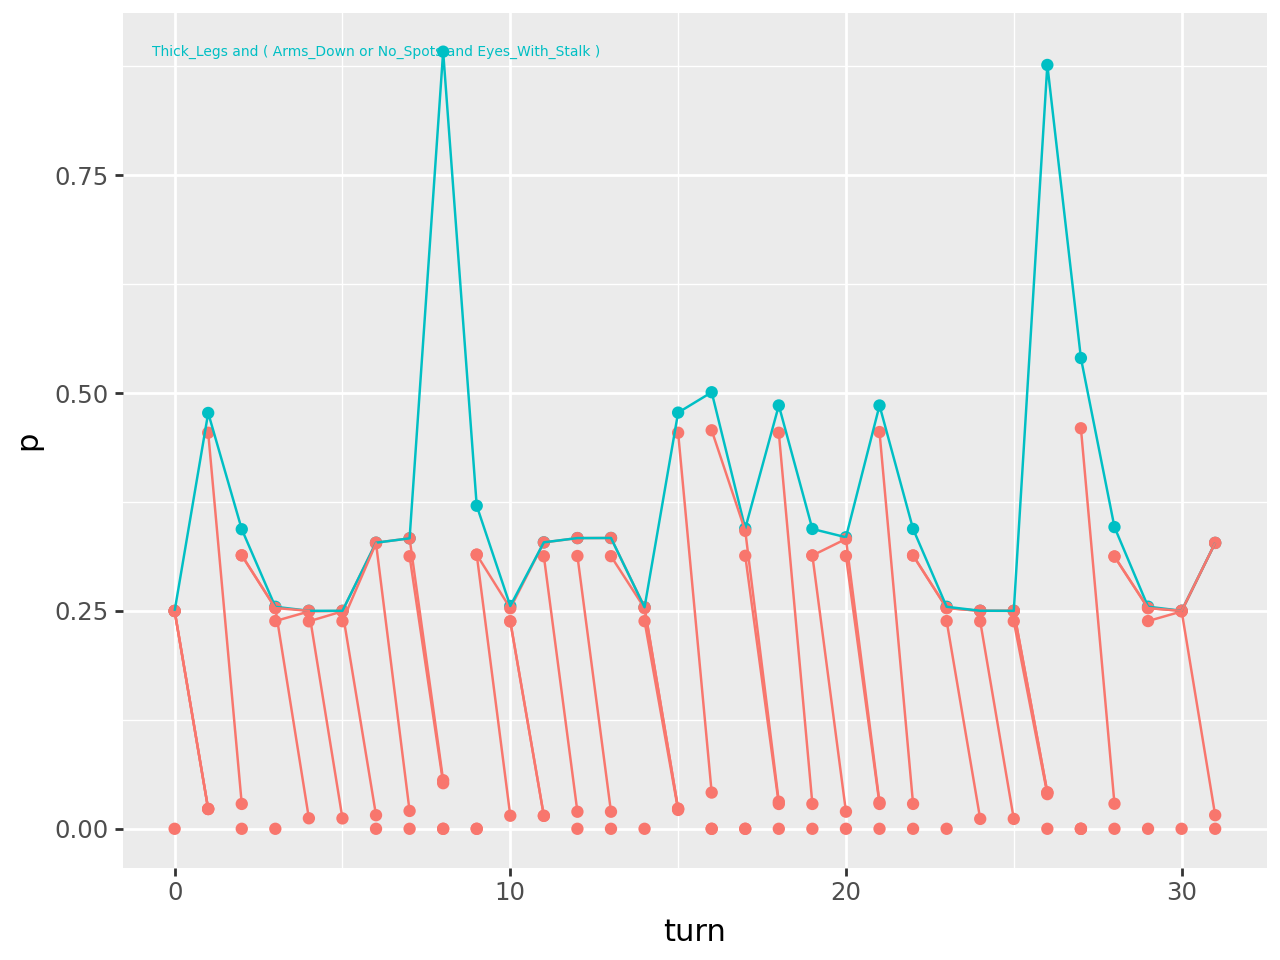

In [58]:
#remove small ps for plotting

(
    ggplot(plot_it, aes("turn","p",group= "rule", color= "rule_disp_c"))
    + geom_point()
    + geom_line()
    + geom_text(aes(label = "rule_disp"), size = 5, nudge_x = -2)
    + xlim(0,max(plot_it["turn"])) 
    + theme(legend_position="none")
)